Цель - предсказать пола клиента по транзакциям.

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [2]:
!git clone https://github.com/alexey9019/data.git

Cloning into 'data'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [0]:
tr_mcc_codes = pd.read_csv('/content/data/tr_mcc_codes.csv', sep = ';', index_col = 'mcc_code')
tr_types = pd.read_csv('/content/data/tr_types.csv', sep = ';', index_col = 'tr_type')
transactions = pd.read_csv('/content/data/transactions.csv', index_col = 'customer_id')
gender_train = pd.read_csv('/content/data/gender_train.csv', index_col = 'customer_id')
gender_test = pd.read_csv('/content/data/gender_test.csv', index_col = 'customer_id')

transactions_train = transactions.join(gender_train, how = 'inner')
transactions_test = transactions.join(gender_test, how = 'inner')

In [0]:
# создадим функции для построения классификатора 
# оценим результаты и построим прогноз для тестовых пользователей
# cv_score - cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res = xgb.cv(params, xgb.DMatrix(train, y_true),
               early_stopping_rounds = 10, maximize = True, 
               num_boost_round = 10000, nfold = 5, stratified = True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-vali hi dation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                     cv_res.loc[index_argmax]['test-auc-std'],
                                                                     index_argmax))

# построим модель и выведем результаты классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names = list(train.columns)), 
              num_boost_round = num_trees, maximize = True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names = list(train.columns)))
    submission = pd.DataFrame(index = test.index, data = y_pred, columns = ['probability'])
    return clf, submission

# отобразим важность переменной
def draw_feature_importances(clf, top_k = 10):
    plt.figure(figsize = (10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key = lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align = 'center', color = 'red')
    plt.yticks(y_pos, importances.keys(), fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title('Важность переменной', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [0]:
# зададим параметры
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation_basic)

In [7]:
# выведем результат
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-vali hi dation, ROC AUC: 0.611+-0.064, Trees: 50


In [0]:
# результат классификации тестовых пользователей
clf, submission = fit_predict(params, 70, data_train, data_test, target)

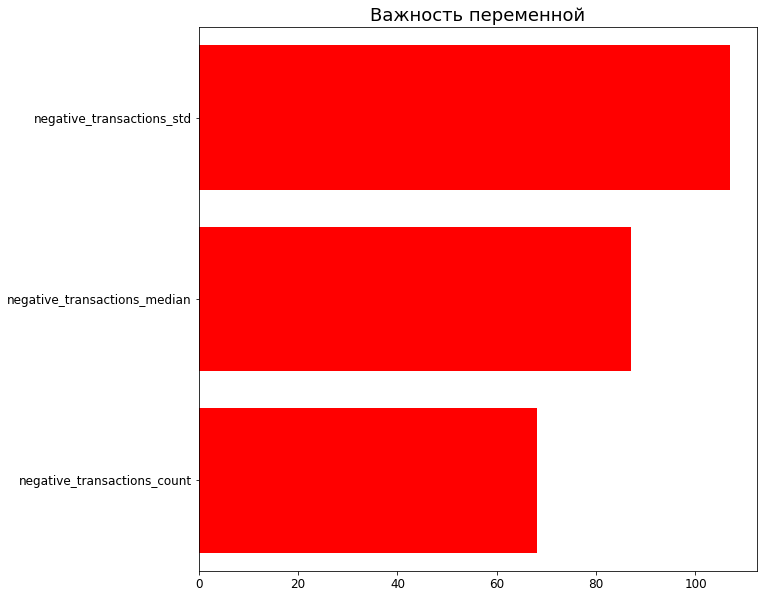

In [9]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/basic_features_submission.csv')

In [0]:
# используем данные о том, где совершались транзакции
# предполагаем, что мужчины чаще будут покупать цветы (mcc_code 5992 - флористика)
for df in [transactions_train, transactions_test]:
    df['mcc_code'] == 5992
    df['mcc'] = df['mcc_code']

In [0]:
# используем медиану, среднеквадратичное отклонение и количество
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['mcc_code'].value_counts(normalize = True).add_prefix('mcc_code_')))
    features.append(pd.Series(x['mcc'].value_counts(normalize = True).add_prefix('mcc_')))
    
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    
    return pd.concat(features)

In [0]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .apply(features_creation_advanced).unstack(-1)

In [14]:
# выведем результат
target = data_train.join(gender_train, how = 'inner')['gender']
cv_score(params, data_train, target)

Cross-vali hi dation, ROC AUC: 0.808+-0.075, Trees: 38


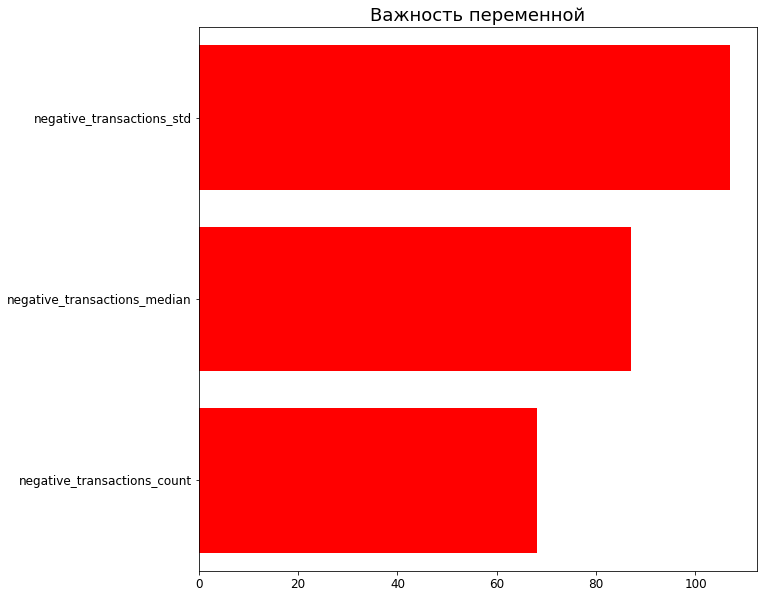

In [15]:
# отобразим важность переменной
draw_feature_importances(clf, 10)

In [0]:
# сохраним в файл
submission.to_csv('/content/data/submission_advanced.csv')